In [1]:
import pickle
import numpy as np
import tensorflow as tf
from preppy import Preppy
from seq2seq import Model
from tensorflow.contrib.seq2seq import *
from tensorflow.python.layers.core import Dense

np.set_printoptions(threshold=np.nan)

In [39]:
params = {
    'embedding_size': 50,
    'vocab_size': 0,
    'hidden_size': 64,
    'n_layers': 1,
    
    'epochs': 10,
    'batch_size': 32,
    
    'grad_clip': 5.0,
    'learning_rate': 0.001,
    
    'save_path' : './Model/Seq2seq/model.ckpt'
}


Make a dataset by reading the train 

In [3]:
def expand(x):
    x['length'] = tf.expand_dims(tf.convert_to_tensor(x['length']),0)
    return x

def deflate(x):
    x['length'] = tf.squeeze(x['length'])
    return x

def tokenizer(sentence):
    return sentence.split()

def save_params(params):
    with open('./Model/Seq2seq/params.pkl', 'wb') as out_file:
        pickle.dump(params, out_file)

def load_params():
    with open('./Model/Seq2seq/params.pkl', 'rb') as in_file:
        return pickle.load(in_file)

In [4]:
preppy = pickle.load(open('./data/seq2seq/preppy.pkl','rb'))
params["vocab_size"] = len(preppy.vocab)
tf.reset_default_graph()
dataset_train = tf.data.TFRecordDataset(['./data/seq2seq/train.tfrecord']).map(preppy.parse)
dataset_val = tf.data.TFRecordDataset(['./data/seq2seq/val.tfrecord']).map(preppy.parse)

In [5]:
dataset_train.output_shapes

{'sentence': TensorShape([Dimension(None)])}

In [6]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))

In [7]:
batched_train = dataset_train.padded_batch(32,padded_shapes={
    "sentence":tf.TensorShape([None])
})

batched_val = dataset_val.padded_batch(32,padded_shapes={
    "sentence":tf.TensorShape([None])
})

handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(
    handle, batched_train.output_types, batched_train.output_shapes)

next_item = iterator.get_next()

In [8]:
batched_train.output_shapes

{'sentence': TensorShape([Dimension(None), Dimension(None)])}

In [9]:
iterator_train = batched_train.make_initializable_iterator()
iterator_val = batched_val.make_initializable_iterator()

handle_train = sess.run(iterator_train.string_handle())
handle_val = sess.run(iterator_val.string_handle())

In [11]:
M = Model(next_item, params)
sess.run(tf.global_variables_initializer())

In [40]:
saver = tf.train.Saver()
saver.restore(sess, params["save_path"])

INFO:tensorflow:Restoring parameters from ./Model/Seq2seq/model.ckpt


In [41]:
loss_train = []
loss_val = []
flag = 0
for epoch in range(params["epochs"]):
    print("Epoch: %d"%(epoch))
    sess.run(iterator_train.initializer)
    print("Training")
    while True:
        try:
            sen, logits, _, loss = sess.run([M.sentence, M.logits, M.train_op, M.loss],feed_dict={handle: handle_train, M.lr: params["learning_rate"]})
            loss_train.append(loss)
            #print(loss)
            #print(np.shape(sen))
            #print(np.shape(logits.rnn_output))
        except tf.errors.OutOfRangeError:
            break
        except tf.errors.DataLossError:
            break
    
    print("Validation")
    sess.run(iterator_val.initializer)
    while True:
        try:
            loss, logits = sess.run([M.loss, M.logits], feed_dict={handle: handle_val})
            loss_val.append(loss)
            if flag == 0:
                print(logits.sample_id)
                flag = 1
        except tf.errors.OutOfRangeError:
            break
        except tf.errors.DataLossError:
            break

print("Training and Validation Finish")

# Save Model
saver = tf.train.Saver()
saver.save(sess, params["save_path"])
save_params(params["save_path"])

print('Model Trained and Saved')




Epoch: 0
Training
Validation
[[   1    4    5    6    7    8    3    5 1162    5   11   12  556   14
     4   16    3    3    4    2    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5]
 [   1    5   18   19    7    2    3   22   23   24    3    2    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5]
 [   1   25   26   24   14   27   26   24   14   28 1256   30   31   32
    26   14   33    2    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
 

Epoch: 1
Training
Validation
Epoch: 2
Training
Validation
Epoch: 3
Training
Validation
Epoch: 4
Training
Validation
Epoch: 5
Training
Validation
Epoch: 6
Training
Validation
Epoch: 7
Training
Validation
Epoch: 8
Training
Validation
Epoch: 9
Training
Validation
Training and Validation Finish
Model Trained and Saved


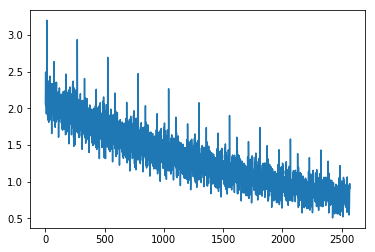

In [42]:
import matplotlib.pyplot as plt
plt.plot(loss_train)
plt.show()

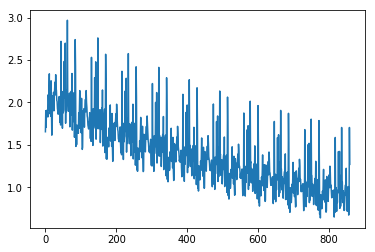

In [43]:
import matplotlib.pyplot as plt
plt.plot(loss_val)
plt.show()

In [44]:
print(logits.sample_id)

[[   1   25    4  278  194  591  119  111    2    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5]
 [   1   13 3813  508    3 3629   11   25  346 1222 1223    2    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5    5    5    5    5    5    5    5    5    5    5    5
     5    5    5